## **ENERGY Optimization Project**
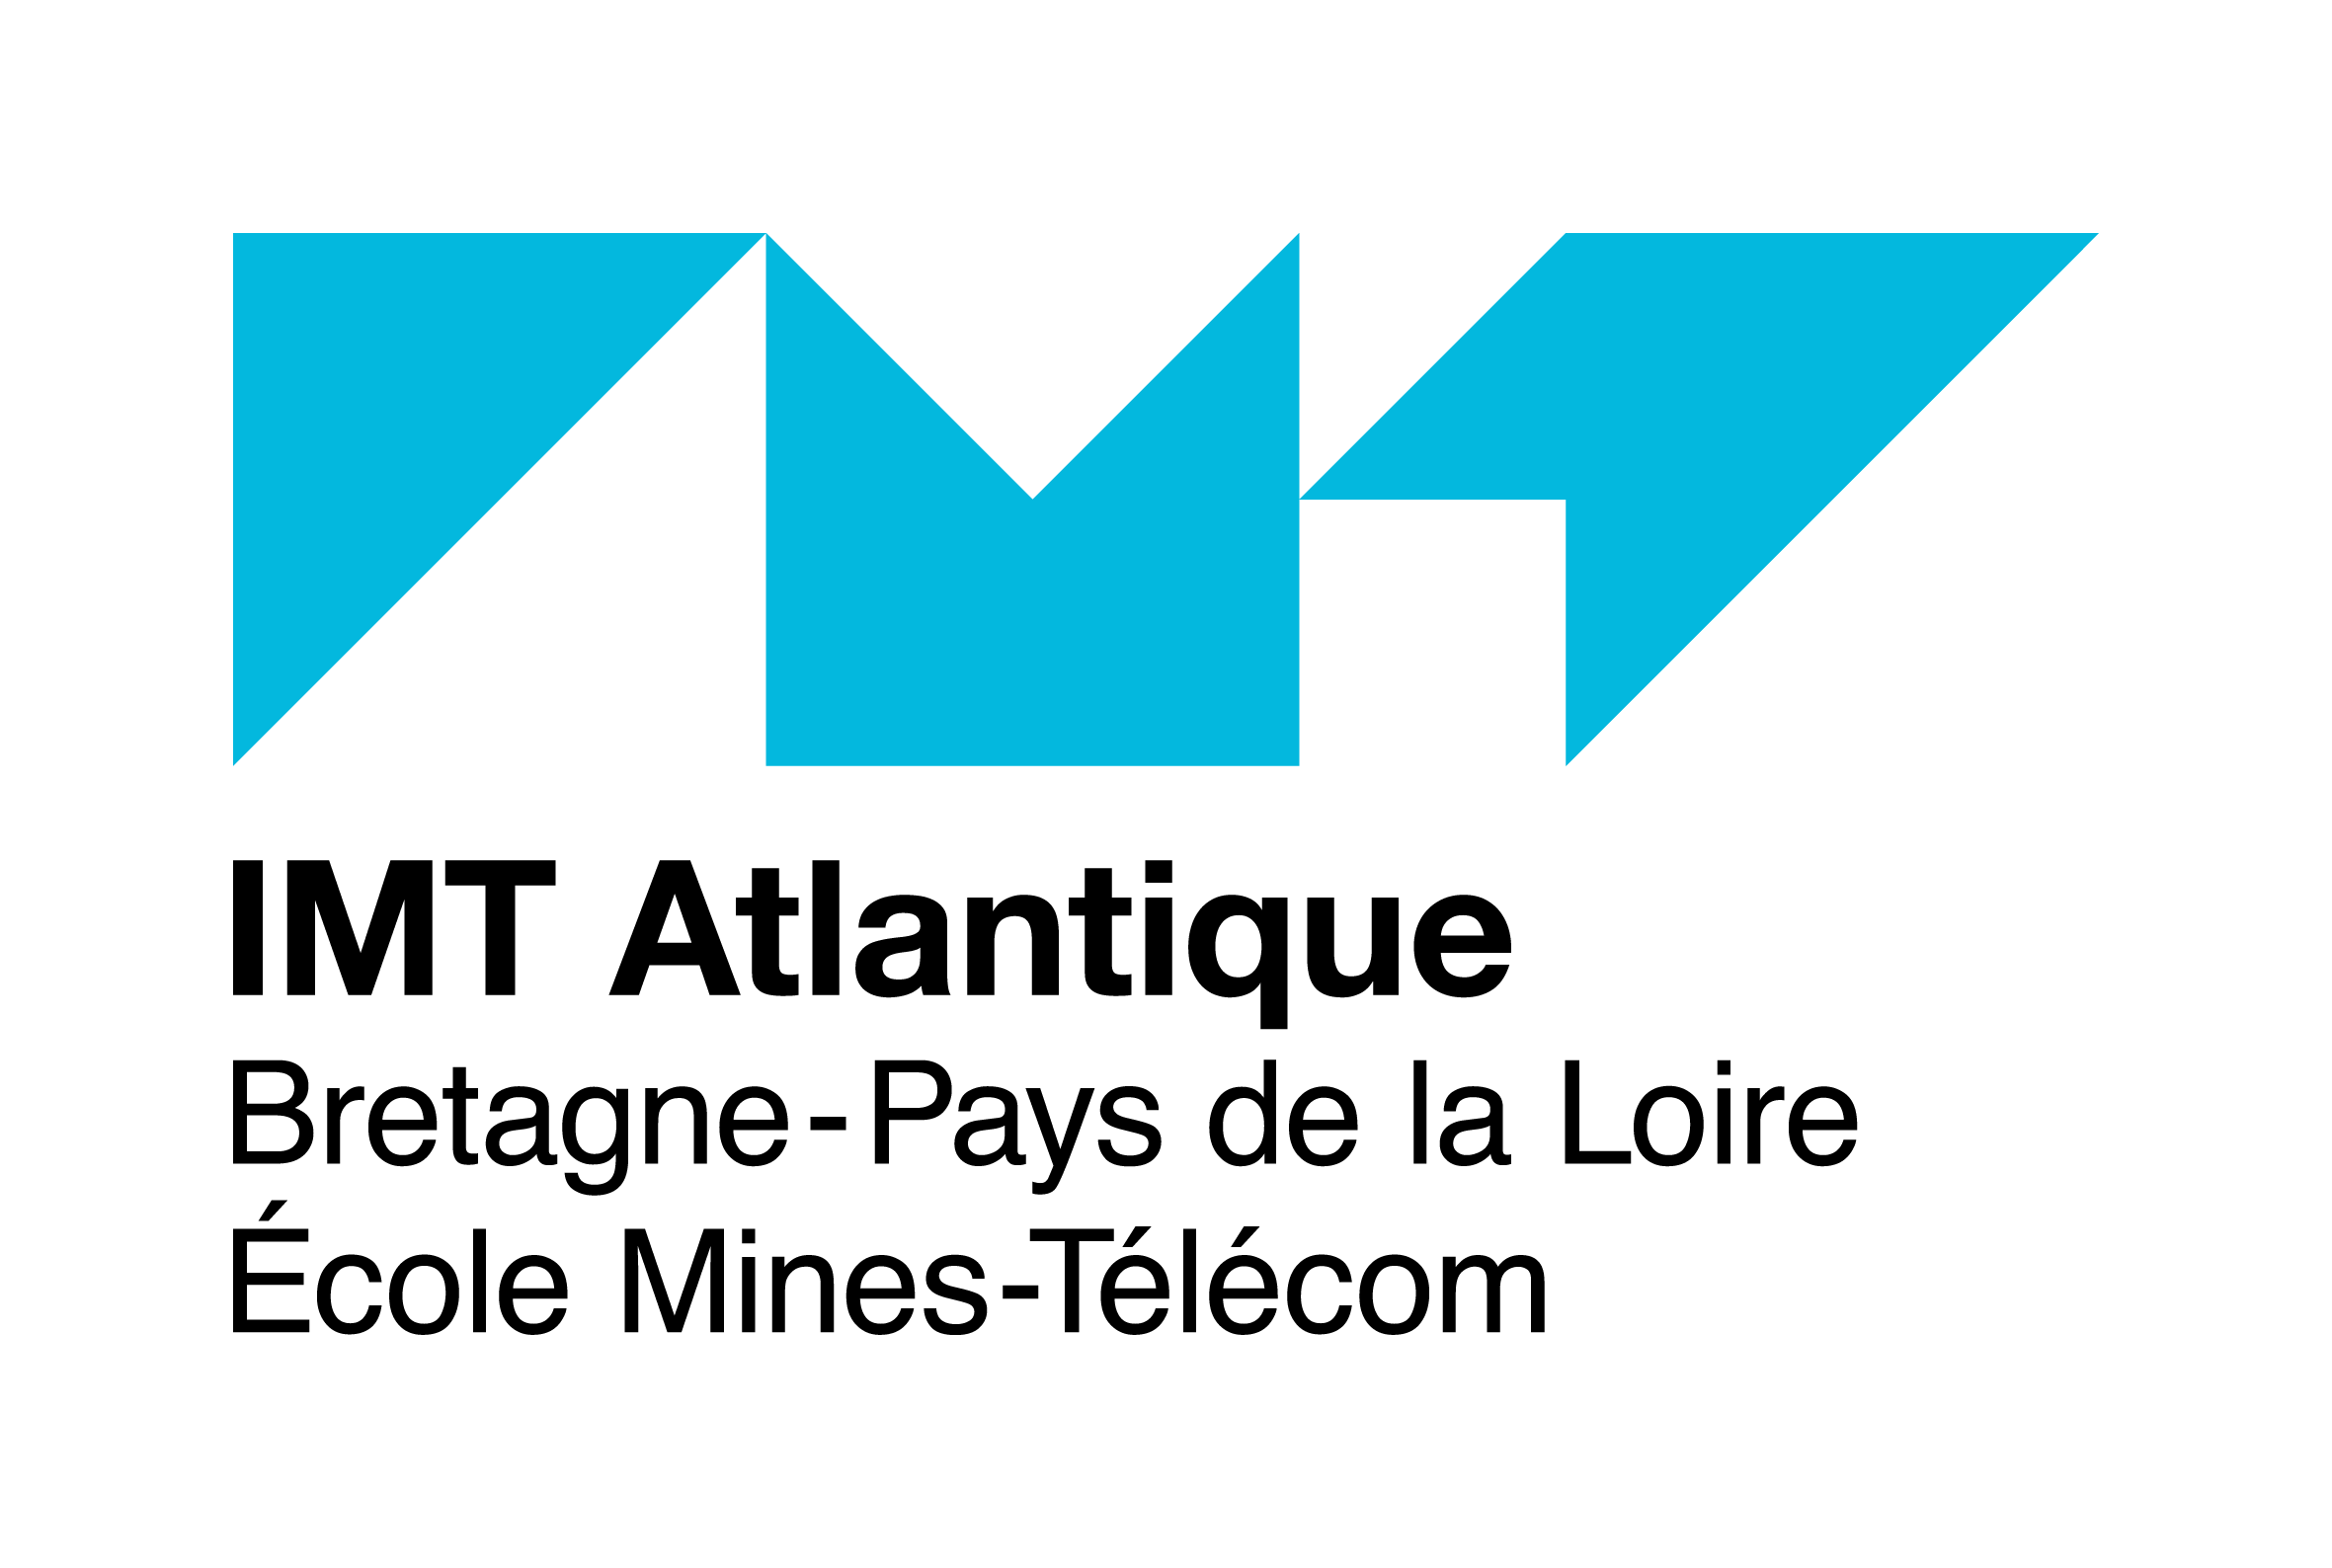
**Group Members**
1.   Muhammad Waqas Saleem
2.   Riccardo D’Alessandro 
3.   Jean tabet



## Data Load

In [38]:
import sys
print(sys.executable)
%matplotlib inline

import numpy as np
print(np.__version__)

import pandas as pd
from pulp import *
import matplotlib.pyplot as plt


c:\Program Files\Python313\python.exe
1.26.4


In [39]:

def read_excel_data(filename, sheet_name):
        data = pd.read_excel(filename, sheet_name=sheet_name, header=None)
        values = data.values
        return values

file_path = "C:\\Users\\vikic\\Desktop\\ME3+\\Python\\NEW_PROJECT_OPT\\data.xlsx"
filename = file_path
sheet_name = "Lines"
lines = read_excel_data(filename, sheet_name)[1:,:]
max_line_load = read_excel_data(filename, sheet_name)[1:,4]
                                                      
sheet_name = "Buses"
buses = read_excel_data(filename, sheet_name)[1:,:]
battery_nodes = read_excel_data(filename, sheet_name)[1:,6]
Nb = buses[:,1].size
Nl = lines[:,1].size
genCost = buses[:,5]
genMax = buses[:,4]
Pmax = sum(genMax)
sheet_name = "Loads"
loads = read_excel_data(filename, sheet_name)[2:,1:Nb+1]
sheet_name = "Loads"
max_load = sum(read_excel_data(filename, sheet_name)[2:, 15])
print(max_load)
sheet_name = "PV production"
maxPower_PV = read_excel_data(filename, sheet_name)[2:,1:Nb+1]/1000
ideal_PV_Generation = np.sum(maxPower_PV) 

sheet_name = "Wind production"
maxPower_WT = read_excel_data(filename, sheet_name)[2:,1:Nb+1]/1000
ideal_WT_Generation = np.sum(maxPower_WT) 


chEfficiency = 0.85
disEfficiency = 0.75

print(Pmax)
print(ideal_PV_Generation, ideal_WT_Generation)


98.097035
25
35.9260504 81.23110299999999


In [40]:
Nt= 24
# create incidence matrix
Mi = np.zeros((Nl,Nb),int)
for l in range(Nl):
    i = int(lines[l,0])
    j = int(lines[l,1])
    Mi[l, i-1] = -1
    Mi[l, j-1] = 1

set_I = [i for i in range(1,Nb+1)]  # set of buses
set_L = [i for i in range(1,Nl+1)]  # set of electrical lines
set_T = [i for i in range(1,Nt+1)]  # set of time steps

### Optimization Function

In [ ]:
from pulp import LpProblem, LpMinimize, LpVariable, lpSum

# Define the problem
electrical_Network = LpProblem("electrical_Network", LpMinimize)

# Create variables
Pg_it = LpVariable.dicts('Pg_it', (set_I, set_T), 0, Pmax, cat='Continuous')         # Generated powers in each node
PL_lt = LpVariable.dicts('Pl_it', (set_L, set_T), -Pmax, Pmax, cat='Continuous')     # Transferred powers
P_it = LpVariable.dicts('P_it', (set_I, set_T), -Pmax, Pmax, cat='Continuous')       # Injected powers
Pg_PV_it = LpVariable.dicts('Pg_PV_it', (set_I, set_T), 0, None, cat='Continuous')   # Solar power
Pg_WT_it = LpVariable.dicts('Pg_WT_it', (set_I, set_T), 0, None, cat='Continuous')   # Wind power

# Add battery variables
B_ch = LpVariable.dicts('B_ch', (set_I, set_T), 0, None, cat='Continuous')           # Battery charging power
B_dis = LpVariable.dicts('B_dis', (set_I, set_T), 0, None, cat='Continuous')         # Battery discharging power
E_batt = LpVariable.dicts('E_batt', (set_I, set_T), 0, None, cat='Continuous')       # State of charge of the battery
E_max_i = LpVariable.dicts('E_max_i', set_I, 0, None, cat='Continuous')              # Maximum energy stored in the battery

# Battery cost parameters
battery_investment_cost = 100 # €/kWh
battery_lifetime_years = 8  # years
charging_efficiency = 0.85  # 85%
discharging_efficiency = 0.75  # 75%

# CO2 emission factor
CO2_emission_G= 0.583 #t CO2 eq /MWh
Max_CO2 = 50#t


# Objective function
electrical_Network += lpSum(
    genCost[i-1] * Pg_it[i][t] * 1000 for i in set_I for t in set_T
) + lpSum(
    (battery_investment_cost/(365*battery_lifetime_years))*1000* E_max_i[i] for i in set_I
)

# Energy balance in the nodes
for t in set_T:
    for i in set_I:
        electrical_Network += Pg_it[i][t] + Pg_PV_it[i][t] + Pg_WT_it[i][t] + B_dis[i][t] - B_ch[i][t] - loads[t-1, i-1] == P_it[i][t]

# Energy balance in the network
for t in set_T:
    for i in set_I:
        electrical_Network += P_it[i][t] == lpSum(-Mi[j-1, i-1] * PL_lt[j][t] for j in set_L)

# Maximal power generation (constraint)
for t in set_T:
    for i in set_I:
        electrical_Network += Pg_it[i][t] <= genMax[i-1]

# PV (constraint)
for t in set_T:
    for i in set_I:
        electrical_Network += Pg_PV_it[i][t] <= maxPower_PV[t-1][i-1]

# WT (constraint)
for t in set_T:
    for i in set_I:
        electrical_Network += Pg_WT_it[i][t] <= maxPower_WT[t-1][i-1]

# Line (constraint)
for t in set_T:
    for i in set_I:
        electrical_Network += PL_lt[i][t] <= max_line_load[i-1]
        electrical_Network += PL_lt[i][t] >= - max_line_load[i-1]

# Battery energy balance and discharge constraints
for t in set_T:
    for i in set_I:
        if t == 1:
            # Set an initial state of charge for the first time step
            electrical_Network += E_batt[i][t] == charging_efficiency * B_ch[i][t] - (1 / discharging_efficiency) * B_dis[i][t]
        else:
            # Subsequent time steps
            electrical_Network += E_batt[i][t] == E_batt[i][t-1] + charging_efficiency * B_ch[i][t] - (1 / discharging_efficiency) * B_dis[i][t]
            
            # Discharge should not exceed available energy (for t > 1)
            electrical_Network += B_dis[i][t] <= E_batt[i][t-1]

        # State of charge should not exceed the maximum battery capacity
        electrical_Network += E_batt[i][t] <= E_max_i[i]

# Battery state of charge cannot be negative
for t in set_T:
    for i in set_I:
        electrical_Network += E_batt[i][t] >= 0  # Ensure battery charge is non-negative

# Restrict batteries to only nodes with battery_nodes[i] == 1
for t in set_T:
    for i in set_I:
        if battery_nodes[i-1] == 0:  
            electrical_Network += B_ch[i][t] == 0  
            electrical_Network += B_dis[i][t] == 0  
            electrical_Network += E_batt[i][t] == 0  

# Ensure that E_max_i is positive
for i in set_I:
    electrical_Network += E_max_i[i] >= 0  # Ensure E_max_i is non-negative

# CO2 emission constraint
electrical_Network += lpSum(Pg_it[i][t] * CO2_emission_G for i in set_I for t in set_T) <= Max_CO2





# Solve the problem
electrical_Network.solve()




1

In [64]:
# The problem is solved using PuLP's choice of Solver(the default solver is Coin Cbc)
electrical_Network.solve()

# The status of the solution is printed to the screen
print("Status:", LpStatus[electrical_Network.status])
print(f"Total Cost: {value(electrical_Network.objective):.2f} euro")

# Check the values of E_max_i after solving
#for i in set_I:
    #print(f"Node {i}: Battery Capacity (E_max_i) = {E_max_i[i].varValue:.2f} MWh")


Status: Optimal
Total Cost: 1380.00 euro


# Results


## SOLAR

In [65]:
PV_Values = {(i, t):value(Pg_PV_it[i][t]) for i in set_I for t in set_T}

df_PV = pd.DataFrame(
    {f"Node_{i}": [PV_Values.get((i, t), 0) for t in set_T] for i in set_I},
    index=[f"Hour_{t}" for t in set_T]
)

# Display the table of PV values
print("PV Generation Values (per Hour and Node):")
print(df_PV.to_string(index=True, header=True, line_width=1000))

PV Generation Values (per Hour and Node):
           Node_1  Node_2  Node_3  Node_4  Node_5    Node_6    Node_7  Node_8  Node_9  Node_10  Node_11   Node_12   Node_13   Node_14
Hour_1   0.000000     0.0     0.0     0.0     0.0  0.000000  0.000000     0.0     0.0      0.0      0.0  0.000000  0.000000  0.000000
Hour_2   0.000000     0.0     0.0     0.0     0.0  0.000000  0.000000     0.0     0.0      0.0      0.0  0.000000  0.000000  0.000000
Hour_3   0.000000     0.0     0.0     0.0     0.0  0.000000  0.000000     0.0     0.0      0.0      0.0  0.000000  0.000000  0.000000
Hour_4   0.000000     0.0     0.0     0.0     0.0  0.000000  0.000000     0.0     0.0      0.0      0.0  0.000000  0.000000  0.000000
Hour_5   0.000000     0.0     0.0     0.0     0.0  0.000000  0.000000     0.0     0.0      0.0      0.0  0.000000  0.000000  0.000000
Hour_6   0.000000     0.0     0.0     0.0     0.0  0.000000  0.000000     0.0     0.0      0.0      0.0  0.000000  0.000000  0.000000
Hour_7   0.000000   

## WIND

In [66]:
WT_Values = {(i, t):value(Pg_WT_it[i][t]) for i in set_I for t in set_T}


# Convert the dictionary to a pandas DataFrame for easy table display
df_WT= pd.DataFrame(
    {f"Node_{i}": [WT_Values.get((i, t), 0) for t in set_T] for i in set_I},
    index=[f"Hour_{t}" for t in set_T]
)

# Display the table of PV values
print("WT Generation Values (per Hour and Node):")
print(df_WT.to_string(index=True, header=True, line_width=1000))

WT Generation Values (per Hour and Node):
         Node_1  Node_2    Node_3  Node_4  Node_5    Node_6    Node_7  Node_8  Node_9  Node_10  Node_11  Node_12  Node_13  Node_14
Hour_1      0.0     0.0  0.174169     0.0     0.0  0.108856  0.152398     0.0     0.0      0.0      0.0      0.0      0.0      0.0
Hour_2      0.0     0.0  0.105893     0.0     0.0  0.066183  0.092657     0.0     0.0      0.0      0.0      0.0      0.0      0.0
Hour_3      0.0     0.0  0.124686     0.0     0.0  0.077929  0.109100     0.0     0.0      0.0      0.0      0.0      0.0      0.0
Hour_4      0.0     0.0  0.254875     0.0     0.0  0.159297  0.223015     0.0     0.0      0.0      0.0      0.0      0.0      0.0
Hour_5      0.0     0.0  0.510237     0.0     0.0  0.318898  0.446457     0.0     0.0      0.0      0.0      0.0      0.0      0.0
Hour_6      0.0     0.0  0.734678     0.0     0.0  0.459174  0.642843     0.0     0.0      0.0      0.0      0.0      0.0      0.0
Hour_7      0.0     0.0  1.516086     0.0

## Generation

In [67]:
G_Values = {(i, t):value(Pg_it[i][t]) for i in set_I for t in set_T}


df_G= pd.DataFrame(
    {f"Node_{i}": [G_Values.get((i, t), 0) for t in set_T] for i in set_I},
    index=[f"Hour_{t}" for t in set_T]
)

# Display the table of PV values
print("Generation Values (per Hour and Node):")
print(df_G.to_string(index=True, header=True, line_width=1000))

Generation Values (per Hour and Node):
         Node_1  Node_2  Node_3  Node_4  Node_5    Node_6  Node_7    Node_8  Node_9  Node_10  Node_11  Node_12  Node_13  Node_14
Hour_1      0.0     0.0     0.0     0.0     0.0  0.000000     0.0  0.309817     0.0      0.0      0.0      0.0      0.0      0.0
Hour_2      0.0     0.0     0.0     0.0     0.0  0.000000     0.0  0.362652     0.0      0.0      0.0      0.0      0.0      0.0
Hour_3      0.0     0.0     0.0     0.0     0.0  0.000000     0.0  0.612165     0.0      0.0      0.0      0.0      0.0      0.0
Hour_4      0.0     0.0     0.0     0.0     0.0  0.000000     0.0  0.500174     0.0      0.0      0.0      0.0      0.0      0.0
Hour_5      0.0     0.0     0.0     0.0     0.0  1.355973     0.0  1.300000     0.0      0.0      0.0      0.0      0.0      0.0
Hour_6      0.0     0.0     0.0     0.0     0.0  2.659810     0.0  1.300000     0.0      0.0      0.0      0.0      0.0      0.0
Hour_7      0.0     0.0     0.0     0.0     0.0  0.000000 

## Battery

In [68]:
Bat_Values = {(i, t):value(E_batt[i][t]) for i in set_I for t in set_T}


# Convert the dictionary to a pandas DataFrame for easy table display
df_bat= pd.DataFrame(
    {f"Node_{i}": [Bat_Values.get((i, t), 0) for t in set_T] for i in set_I},
    index=[f"Hour_{t}" for t in set_T]
)

# Display the table of PV values
print("battery Values (per Hour and Node):")
print(df_bat.to_string(index=True, header=True, line_width=1000))

battery Values (per Hour and Node):
           Node_1  Node_2  Node_3  Node_4  Node_5     Node_6  Node_7  Node_8  Node_9  Node_10  Node_11  Node_12  Node_13   Node_14
Hour_1   0.000000     0.0     0.0     0.0     0.0   0.000000     0.0     0.0     0.0      0.0      0.0      0.0      0.0  0.000000
Hour_2   0.000000     0.0     0.0     0.0     0.0   0.000000     0.0     0.0     0.0      0.0      0.0      0.0      0.0  0.000000
Hour_3   0.000000     0.0     0.0     0.0     0.0   0.000000     0.0     0.0     0.0      0.0      0.0      0.0      0.0  0.000000
Hour_4   0.000000     0.0     0.0     0.0     0.0   0.000000     0.0     0.0     0.0      0.0      0.0      0.0      0.0  0.000000
Hour_5   0.000000     0.0     0.0     0.0     0.0   0.000000     0.0     0.0     0.0      0.0      0.0      0.0      0.0  0.000000
Hour_6   0.000000     0.0     0.0     0.0     0.0   0.000000     0.0     0.0     0.0      0.0      0.0      0.0      0.0  0.000000
Hour_7   0.000000     0.0     0.0     0.0     0

## RE Share


In [69]:
df_PV = df_PV.apply(pd.to_numeric, errors='coerce')
df_WT= df_WT.apply(pd.to_numeric, errors='coerce')
df_G= df_G.apply(pd.to_numeric, errors='coerce')


enrgy: 105.4893795
wind share: 67.54
Solar share: 30.49
We are using PV as comapred to maximum capacity: 83.26 % and for the Wind : 81.56 %
RE share is: 98.03 % and generation share is: 9.51 %


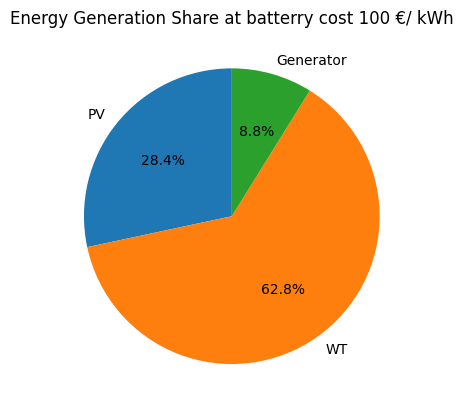

In [74]:
total_PV = df_PV.to_numpy().sum()
total_WT = df_WT.to_numpy().sum()
total_Generator = df_G.to_numpy().sum()

print(f"enrgy: {(total_PV+total_WT+total_Generator)}")
print(f"wind share: {(( total_WT) / max_load) * 100:.2f}")
print(f"Solar share: {(( total_PV) / max_load) * 100:.2f}")
print(f"We are using PV as comapred to maximum capacity: {(total_PV/ideal_PV_Generation)*100:.2f} % and for the Wind : {(total_WT/ideal_WT_Generation)*100:.2f} %")
print(f"RE share is: {((total_PV + total_WT) / max_load) * 100:.2f} % and generation share is: {((total_Generator) / max_load) * 100:.2f} %")

piechat = [total_PV, total_WT, total_Generator]
labels = ['PV', 'WT', 'Generator']
fig1, ax1 = plt.subplots()
ax1.pie(piechat, labels=labels, autopct='%1.1f%%', startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(f'Energy Generation Share at batterry cost {battery_investment_cost} €/ kWh')
plt.show()

## Sensitivity Analysis

### Function 

In [49]:
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, value
import pandas as pd

def optimize_for_battery_costs(cost, CO2):
    
    results = []  # List to store results for each battery cost

    # Reinitialize the problem inside the loop to ensure it starts fresh each time
    electrical_Network = LpProblem("electrical_Network", LpMinimize)

    # Reinitialize variables inside the loop
    Pg_it = LpVariable.dicts('Pg_it', (set_I, set_T), 0, Pmax, cat='Continuous')
    PL_lt = LpVariable.dicts('Pl_it', (set_L, set_T), -Pmax, Pmax, cat='Continuous')
    P_it = LpVariable.dicts('P_it', (set_I, set_T), -Pmax, Pmax, cat='Continuous')
    Pg_PV_it = LpVariable.dicts('Pg_PV_it', (set_I, set_T), 0, None, cat='Continuous')
    Pg_WT_it = LpVariable.dicts('Pg_WT_it', (set_I, set_T), 0, None, cat='Continuous')

    # Add battery variables
    B_ch = LpVariable.dicts('B_ch', (set_I, set_T), 0, None, cat='Continuous')
    B_dis = LpVariable.dicts('B_dis', (set_I, set_T), 0, None, cat='Continuous')
    E_batt = LpVariable.dicts('E_batt', (set_I, set_T), 0, None, cat='Continuous')
    E_max_i = LpVariable.dicts('E_max_i', set_I, 0, None, cat='Continuous')

    # Add the objective function with battery investment cost
    electrical_Network += lpSum(genCost[i-1] * Pg_it[i][t] * 1000 for i in set_I for t in set_T) + \
                          lpSum((cost/(365*battery_lifetime_years))*1000* E_max_i[i] for i in set_I)
                              
    # Energy balance in the nodes
    for t in set_T:
        for i in set_I:
            electrical_Network += Pg_it[i][t] + Pg_PV_it[i][t] + Pg_WT_it[i][t] + B_dis[i][t] - B_ch[i][t] - loads[t-1, i-1] == P_it[i][t]

    # Energy balance in the network
    for t in set_T:
        for i in set_I:
            electrical_Network += P_it[i][t] == lpSum(-Mi[j-1, i-1] * PL_lt[j][t] for j in set_L)

    # Maximal power generation (constraint)
    for t in set_T:
        for i in set_I:
            electrical_Network += Pg_it[i][t] <= genMax[i-1]

    # PV (constraint)
    for t in set_T:
        for i in set_I:
            electrical_Network += Pg_PV_it[i][t] <= maxPower_PV[t-1][i-1]

    # WT (constraint)
    for t in set_T:
        for i in set_I:
            electrical_Network += Pg_WT_it[i][t] <= maxPower_WT[t-1][i-1]

    # Line (constraint)
    for t in set_T:
        for i in set_I:
            electrical_Network += PL_lt[i][t] <= max_line_load[i-1]

    # Battery energy balance and discharge constraints
    for t in set_T:
        for i in set_I:
            if t == 1:
                # Set an initial state of charge for the first time step
                electrical_Network += E_batt[i][t] == charging_efficiency * B_ch[i][t] - (1 / discharging_efficiency) * B_dis[i][t]
            else:
                # Subsequent time steps
                electrical_Network += E_batt[i][t] == E_batt[i][t-1] + charging_efficiency * B_ch[i][t] - (1 / discharging_efficiency) * B_dis[i][t]
                
                # Discharge should not exceed available energy (for t > 1)
                electrical_Network += B_dis[i][t] <= E_batt[i][t-1]

            # State of charge should not exceed the maximum battery capacity
            electrical_Network += E_batt[i][t] <= E_max_i[i]

        # Battery state of charge cannot be negative
        for t in set_T:
            for i in set_I:
                electrical_Network += E_batt[i][t] >= 0  # Ensure battery charge is non-negative
        # Ensure that E_max_i is positive
        for i in set_I:
                electrical_Network += E_max_i[i] >= 0  # Ensure E_max_i is non-negative

        # Restrict batteries to only nodes with battery_nodes[i] == 1
        for t in set_T:
            for i in set_I:
                if battery_nodes[i-1] == 0:  # Assuming `set_I` starts at 1 and aligns with `battery_nodes` index
                    electrical_Network += B_ch[i][t] == 0  # No charging at this node
                    electrical_Network += B_dis[i][t] == 0  # No discharging at this node
                    electrical_Network += E_batt[i][t] == 0  # No energy storage at this node 

        # CO2 emission constraint
        electrical_Network += lpSum(Pg_it[i][t] * CO2_emission_G for i in set_I for t in set_T) <= CO2
        
        



    # Solve the problem
    electrical_Network.solve()

    # Check solver status and log the status and results
    if electrical_Network.status == 1:
        
        PV = {(i, t): value(Pg_PV_it[i][t]) for i in set_I for t in set_T}
        df_PV = pd.DataFrame({f"Node_{i}": [PV.get((i, t), 0) for t in set_T] for i in set_I}, index=[f"Hour_{t}" for t in set_T])

        WT = {(i, t): value(Pg_WT_it[i][t]) for i in set_I for t in set_T}
        df_WT = pd.DataFrame({f"Node_{i}": [WT.get((i, t), 0) for t in set_T] for i in set_I}, index=[f"Hour_{t}" for t in set_T])

        G = {(i, t): value(Pg_it[i][t]) for i in set_I for t in set_T}
        df_G = pd.DataFrame({f"Node_{i}": [G.get((i, t), 0) for t in set_T] for i in set_I}, index=[f"Hour_{t}" for t in set_T])

        # Convert all DataFrames to numeric values
        df_PV = df_PV.apply(pd.to_numeric, errors='coerce')
        df_WT = df_WT.apply(pd.to_numeric, errors='coerce')
        df_G = df_G.apply(pd.to_numeric, errors='coerce')

        # Summing values
        total_PV = df_PV.to_numpy().sum()
        total_WT = df_WT.to_numpy().sum()
        total_Generator = df_G.to_numpy().sum()
        total_RE = total_PV + total_WT

        # Append results
        results.append({
            "energy": (total_PV + total_WT + total_Generator),
            "RE_share": (total_RE / max_load) * 100,
            "generation_share": (total_Generator / max_load) * 100,
            "battery_cost": cost,
            "total_PV": total_PV,
            "total_WT": total_WT,
            "total_RE": total_RE,
            "total_Generator": total_Generator
        })

    else:
        print(f"Optimization did not solve for battery cost: {cost}. Status: {electrical_Network.status}")

    return results


### Battery Cost Analysis with CO2 emission is constant

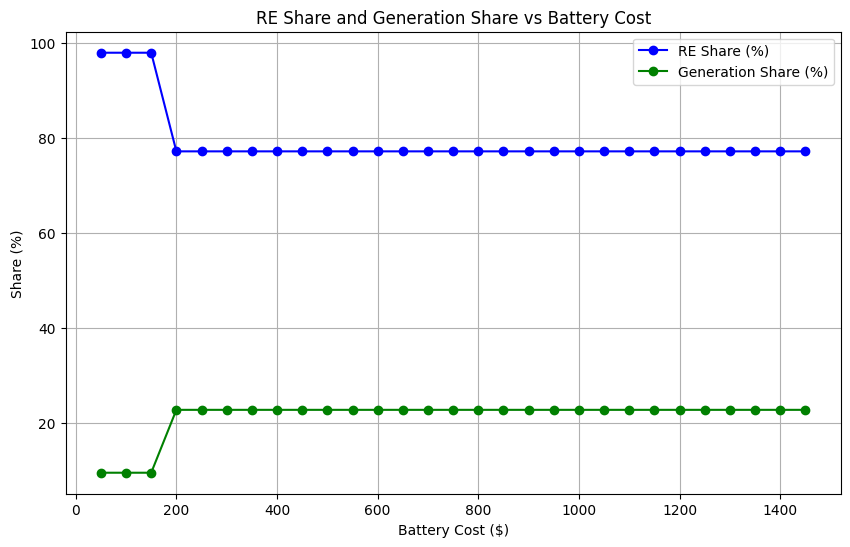

In [50]:
import matplotlib.pyplot as plt

# Define the range of battery costs
battery_costs = range(50, 1500, 50)


# Initialize lists to store RE_share and generation_share values
RE_shares = []
generation_shares = []

# Run sensitivity analysis for each battery cost
for cost in battery_costs:
    # Run the optimization for each cost
    sensitivity_analysis_results = optimize_for_battery_costs(cost,30)
    
    # Extract RE_share and generation_share from the results
    RE_share = sensitivity_analysis_results[0]['RE_share']
    generation_share = sensitivity_analysis_results[0]['generation_share']
    
    # Append to the lists
    RE_shares.append(RE_share)
    generation_shares.append(generation_share)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(battery_costs, RE_shares, label='RE Share (%)', color='blue', marker='o')
plt.plot(battery_costs, generation_shares, label='Generation Share (%)', color='green', marker='o')

# Add labels and title
plt.xlabel('Battery Cost ($)')
plt.ylabel('Share (%)')
plt.title('RE Share and Generation Share vs Battery Cost')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


### Heat Map

Optimization did not solve for battery cost: 100. Status: -1
Optimization did not solve for battery cost: 100. Status: -1
Optimization did not solve for battery cost: 100. Status: -1
Optimization did not solve for battery cost: 200. Status: -1
Optimization did not solve for battery cost: 200. Status: -1
Optimization did not solve for battery cost: 200. Status: -1
Optimization did not solve for battery cost: 300. Status: -1
Optimization did not solve for battery cost: 300. Status: -1
Optimization did not solve for battery cost: 300. Status: -1
Optimization did not solve for battery cost: 400. Status: -1
Optimization did not solve for battery cost: 400. Status: -1
Optimization did not solve for battery cost: 400. Status: -1
Optimization did not solve for battery cost: 500. Status: -1
Optimization did not solve for battery cost: 500. Status: -1
Optimization did not solve for battery cost: 500. Status: -1
Optimization did not solve for battery cost: 600. Status: -1
Optimization did not sol

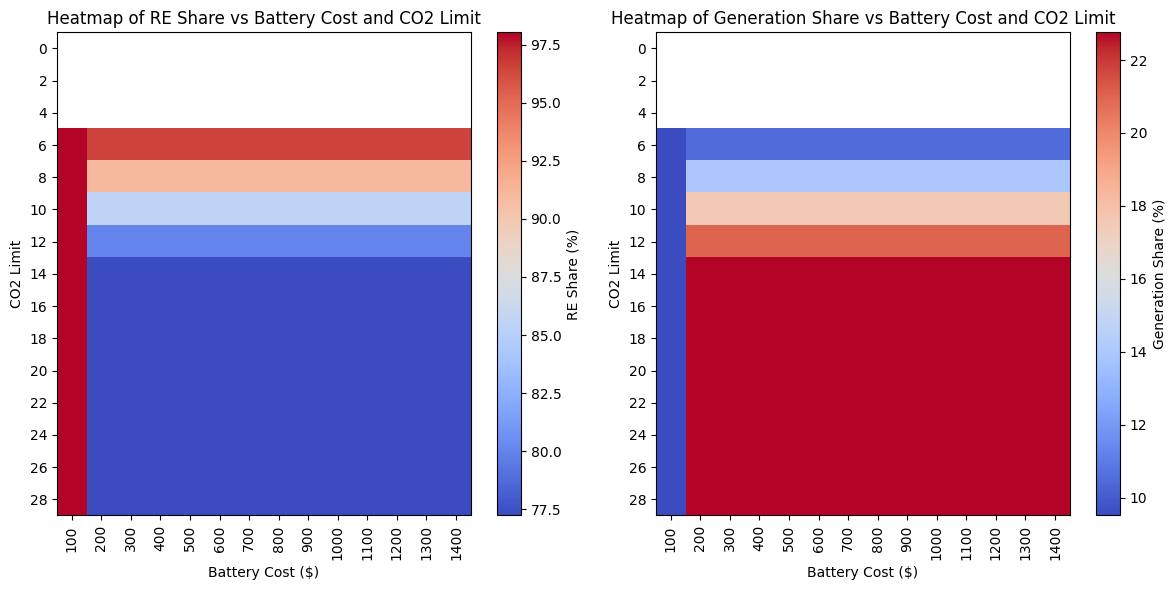

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Define the range of battery costs and CO2 limits
battery_costs = range(100, 1500, 100)
CO2_limits = range(0, 30, 2) 

# Initialize arrays to store RE_share and generation_share values
RE_share_matrix = np.zeros((len(CO2_limits), len(battery_costs)))
generation_share_matrix = np.zeros((len(CO2_limits), len(battery_costs)))

# Run sensitivity analysis for each combination of battery cost and CO2 limit
for i, cost in enumerate(battery_costs):
    for j, co2_limit in enumerate(CO2_limits):
        # Run the optimization for each combination of cost and CO2 limit
        sensitivity_analysis_results = optimize_for_battery_costs(cost, co2_limit)
        
        if sensitivity_analysis_results:  # Check if there are results
            # Extract RE_share and generation_share from the results
            RE_share_matrix[j, i] = sensitivity_analysis_results[0].get('RE_share', 0)
            generation_share_matrix[j, i] = sensitivity_analysis_results[0].get('generation_share', 0)
        else:
            # If no results, set values to NaN (or another placeholder value)
            RE_share_matrix[j, i] = np.nan
            generation_share_matrix[j, i] = np.nan

# Plot the heatmap for RE share
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(RE_share_matrix, cmap='coolwarm', aspect='auto', interpolation='nearest')
plt.colorbar(label="RE Share (%)")
plt.xlabel('Battery Cost ($)')
plt.ylabel('CO2 Limit')
plt.title('Heatmap of RE Share vs Battery Cost and CO2 Limit')
plt.xticks(ticks=np.arange(len(battery_costs)), labels=battery_costs, rotation=90)
plt.yticks(ticks=np.arange(len(CO2_limits)), labels=CO2_limits)

# Plot the heatmap for Generation share
plt.subplot(1, 2, 2)
plt.imshow(generation_share_matrix, cmap='coolwarm', aspect='auto', interpolation='nearest')
plt.colorbar(label="Generation Share (%)")
plt.xlabel('Battery Cost ($)')
plt.ylabel('CO2 Limit')
plt.title('Heatmap of Generation Share vs Battery Cost and CO2 Limit')
plt.xticks(ticks=np.arange(len(battery_costs)), labels=battery_costs, rotation=90)
plt.yticks(ticks=np.arange(len(CO2_limits)), labels=CO2_limits)

plt.tight_layout()
plt.show()
